In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import sympy
import sklearn
import sklearn.base
from sklearn.dummy import DummyRegressor

In [2]:
class Loss(object):    
    def __init__(self):
        self.lipschitz = None
    
    def calculate(self, prediction_vector, true_vector):
        pass
    
    def calculate_gradient(self, predcition_vector, true_vector):
        pass

class MeanSquaredLoss(Loss):
    def __init__(self):
        #lipschitz constant
        self.L = 1
    
    def calculate(self, prediction_vector, true_vector):
        return np.sum((prediction_vector - true_vector)**2) / 2
    
    def calculate_gradient(self, prediction_vector, true_vector):
        return (prediction_vector - true_vector)
    
class AbsoluteLoss(Loss):
    def __init__(self):
        self.L = 1
        
    def calculate(self, prediction_vector, true_vector):
        return np.sum(np.abs(prediction_vector - true_vector))

    def calculate_gradient(self, prediction_vector, true_vector):
        return np.sign(prediction_vector - true_vector)

In [3]:
class GradientBoostingAlgorithm1(object):
    def __init__(self, baselearner, loss, verbose=False):
        
        self.base_learner = sklearn.base.clone(baselearner)
        self.loss = loss
        
        self.models = []
        self.weights = []
     
        self.is_fit = False
        self.verbose = verbose
        #weight update
        #w_{t+1} = min(w_t, 1/(2L)\xi(F(X_t), y))
        #\sum_{i = 1}^{T}
        #<C(F_T(X), f> -> max 
        #\sum_{i=0}^{sample_size} <subgradC(F_t, y), f> 

    def fit(self, X, y_true, num_steps):
        self.models.clear()
        self.weights.clear()
        
        for i in tqdm_notebook(range(num_steps)): 
            base_learner = sklearn.base.clone(self.base_learner)
            current_prediction = self.predict(X, i)
            grad_i = self.loss.calculate_gradient(current_prediction, y_true)
            if self.verbose:
                print('Sample weight {}'.format(grad_i))
            base_learner.fit(X, y_true, sample_weight = grad_i)
            
            if i == 0:
                weight_i = 1.0
            else:
                weight_i = min(self.weights[-1], np.mean(grad_i) / (2  * self.loss.L))
            
            self.weights.append(weight_i)
            self.models.append(base_learner)
            
        self.is_fit = True

    def predict(self, X_test, n_steps=None) -> np.array:
        if n_steps is None:
            n_steps = len(self.weights)
        prediction = 0
        if self.verbose:
            print('Number of steps {}'.format(n_steps))
        for i in range(n_steps):
            prediction += self.weights[i] * self.models[i].predict(X_test)
        return prediction

In [4]:
class GradientBoostingAlgorithm2(object):
    def __init__(self, baselearner, loss:Loss, verbose=False):
        
        self.base_learner = sklearn.base.clone(baselearner)
        self.loss = loss
        
        self.models = []
        self.weights = []

        self.verbose = verbose
        self.is_fit = False
        
    def fit(self, X, y_true, num_steps):
        self.models.clear()
        self.weights.clear()
        residual = np.copy(y_true)
        
        for i in range(num_steps):
            base_learner = sklearn.base.clone(self.base_learner)
            current_prediction = self.predict(X, i)
            base_learner.fit(X, -self.loss.calculate_gradient(current_prediction, y_true))
            
            #base_learner.fit(X, residual)
            ith_base_prediction = base_learner.predict(X)
            self.models.append(base_learner)
            if self.verbose:
                print('ith base', ith_base_prediction)
            #print('residual', residual)
            
            if i == 0:
                weight_i = 1.0
            else:
                weight_i =  1 / (4 * self.loss.L)
            #residual += weight_i * ith_base_prediction
            self.weights.append(weight_i)
        self.is_fit = True
    
    def predict(self, X_test, n_steps=None):
        if n_steps is None:
            n_steps = len(self.weights)
        prediction = 0
        if self.verbose:
            print('Number of steps {}'.format(n_steps))
        for i in range(n_steps):
            prediction += self.weights[i] * self.models[i].predict(X_test)      
        return prediction

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin

from tqdm import tqdm_notebook

In [6]:
class AGB_Tree(BaseEstimator, RegressorMixin):
    def __init__(self, tree, verbose=False):
        self.tree = tree
    
        self.is_fit = False
        self.verbose = verbose
    
    def fit(self, X_train, y_train, current_prediction, real_y):
        self.tree.fit(X_train, y_train)
        
        weights = []
        #for squared error loss
        #weight for every leaf can be calculated as mean value of corresponding leaf entries
        #item here represents the index array for each leaf
        #be careful with base learner not to have too many leaves
        leaf_indices = self.tree.apply(X_train)

        for item in map(lambda index: np.arange(0, X_train.shape[0])[leaf_indices == index],
                            np.arange(0, self.tree.tree_.node_count)):
            if self.verbose:
                print('item ', item)
            if len(item) > 0:
                group_y = real_y[item]
                group_predictions = current_prediction[item]
                group_weight = 2 * np.sum(group_y - group_predictions) / item.shape[0]
                if self.verbose:
                    print('Numerator:{}'.format(2 * np.sum(group_y - group_predictions) / item.shape[0]))
                    print('Denominator:{}'.format(item.shape[0]))
            else:
                #probably shouldn't happen, but still
                group_weight = 0

            if self.verbose:
                print('Group weight {}'.format(group_weight))
            weights.append(group_weight)

        self.weights = np.array(weights, dtype=np.float)
        assert self.tree.tree_.node_count == len(weights)
        self.is_fit = True
    
    def predict(self, X_test):
        assert self.is_fit
        leaf_indices = self.tree.apply(X_test)
        return self.weights[leaf_indices]

class CombineClassifier(BaseEstimator, RegressorMixin):
    def __init__(self, first, second, coef1 = 1, coef2 = 1):
        self.first = first
        self.coef_first = coef1
        self.second = second
        self.coef_second = coef2
        self.is_fit = True
    
    def predict(self, X_test):
      #  assert self.first.is_fit and self.second.is_fit
        return self.coef_first * self.first.predict(X_test) + self.coef_second * self.second.predict(X_test)

In [7]:
from datetime import datetime
from time import time

In [8]:
class GradientBoostingAlgorithm3(object):
    def __init__(self, baselearner, loss, step, verbose=False):
        self.base_learner = sklearn.base.clone(baselearner)
        self.loss = loss
        self.step = step
        
        self.gammas = []
        self.lambdas = []
        self.Fs = []
        self.Gs = []

        
        self.verbose = verbose
        self.is_fit = False
    
    def calculate_parameters(self, num_steps):
        self.lambdas.clear()
        self.gammas.clear()
        self.lambdas.append(0)
        self.gammas.append(1)
        
        for i in range(num_steps):
            self.lambdas.append((1 + np.sqrt(1 + self.lambdas[i])) / 2)
            self.gammas.append((1 - self.lambdas[i])/self.lambdas[i + 1])

        
    def fit(self, X, y_true, num_steps):
        self.Fs.clear()
        self.Gs.clear()
        
        self.calculate_parameters(num_steps)
    
        first_regressor = DummyRegressor()
        first_regressor.fit(X, y_true)
        self.Fs.append(first_regressor)
        self.Gs.append(first_regressor)
        
        for i in tqdm_notebook(range(num_steps)):
            if self.verbose:
                print('Step {}'.format(i))
            base_learner = AGB_Tree(sklearn.base.clone(self.base_learner))
            
            #fit tree to residuals
            current_prediction = self.Gs[i].predict(X)
            antigradient = -self.loss.calculate_gradient(current_prediction, y_true)
            
            base_learner.fit(X, antigradient, current_prediction, y_true)
            self.Fs.append(CombineClassifier(self.Gs[i], base_learner, 1, self.step))
            self.Gs.append(CombineClassifier(self.Fs[i + 1], self.Fs[i], 1 - self.gammas[i], self.gammas[i]))           
        self.is_fit = True
                
    def predict(self, X_test, n_steps=None):
        return self.Fs[n_steps].predict(X_test)

In [67]:
class CombineRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators:list, coeffecients:list, num_steps:int):
        self.estimators = estimators
        self.coeffecients = coeffecients
        self.num_steps = num_steps
        self.is_fit = True
        self.calculate_parameters(num_steps)
        
    @classmethod    
    def create(cls, model, weight, num_steps):
        return cls([model], [weight], num_steps)
        
    def append(self, model, weight):
        self.estimators.append(model)
        self.coeffecients.append(weight)
        
    def calculate_parameters(self, num_steps):
        self.gammas = []
        self.lambdas = []
        
        self.lambdas.append(0)
        self.gammas.append(1)
        
        for i in range(num_steps):
            self.lambdas.append((1 + np.sqrt(1 + self.lambdas[i])) / 2)
            self.gammas.append((1 - self.lambdas[i])/self.lambdas[i + 1])

    def predict(self, X_test, calc_steps, return_last=1):
        results = []
        if calc_steps == 0:
            results.append(self.estimators[0].predict(X_test))
        elif calc_steps == 1:
            results.append(self.estimators[0].predict(X_test))
            results.append(self.estimators[0].predict(X_test) + self.coeffecients[1] * self.estimators[1].predict(X_test))
        else:
            results.append(self.estimators[0].predict(X_test))
            results.append(self.estimators[0].predict(X_test) + self.coeffecients[1] * self.estimators[1].predict(X_test))
            for i in range(2, calc_steps):
     #           print(i)
                results.append((1 - self.gammas[i - 2]) * results[i - 1] + self.gammas[i - 2] * results[i - 2] + self.estimators[i].predict(X_test) * self.coeffecients[i])
        return results[-return_last:]
                
                
    def calculate_G_predictions(self, X, i):
        if i == 0:
            prediction = self.predict(X, 0)[0]
            return prediction
        else:
            prediction = self.predict(X, i, return_last = 2)
         #   print(prediction)
            F_t1, F_t2 = prediction
            return (1 - self.gammas[i - 1]) * F_t2 + self.gammas[i - 1] * F_t1    

In [69]:
class GradientBoostingAlgorithm3_version2(object):
    def __init__(self, baselearner, loss, step, verbose=False):
        self.base_learner = sklearn.base.clone(baselearner)
        self.loss = loss
        self.step = step
        
            
        self.verbose = verbose
        self.is_fit = False
        
    def fit(self, X, y_true, num_steps):            
        first_regressor = DummyRegressor()
        first_regressor.fit(X, y_true)
    
        self.Fs = CombineRegressor.create(first_regressor, self.step, num_steps=num_steps)
        
        for i in tqdm_notebook(range(num_steps)):
            if self.verbose:
                print('Step {}'.format(i))
            base_learner = AGB_Tree(sklearn.base.clone(self.base_learner))
            
            #fit tree to residuals
            current_prediction = self.Fs.calculate_G_predictions(X, i)
            antigradient = -self.loss.calculate_gradient(current_prediction, y_true)
            
            base_learner.fit(X, antigradient, current_prediction, y_true)
            self.Fs.append(base_learner, self.step)         
        self.is_fit = True
                
    def predict(self, X_test, n_steps=None):
        return self.Fs.predict(X_test, calc_steps=n_steps)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Ste

Step 924
Step 925
Step 926
Step 927
Step 928
Step 929
Step 930
Step 931
Step 932
Step 933
Step 934
Step 935
Step 936
Step 937
Step 938
Step 939
Step 940
Step 941
Step 942
Step 943
Step 944
Step 945
Step 946
Step 947
Step 948
Step 949
Step 950
Step 951
Step 952
Step 953
Step 954
Step 955
Step 956
Step 957
Step 958
Step 959
Step 960
Step 961
Step 962
Step 963
Step 964
Step 965
Step 966
Step 967
Step 968
Step 969
Step 970
Step 971
Step 972
Step 973
Step 974
Step 975
Step 976
Step 977
Step 978
Step 979
Step 980
Step 981
Step 982
Step 983
Step 984
Step 985
Step 986
Step 987
Step 988
Step 989
Step 990
Step 991
Step 992
Step 993
Step 994
Step 995
Step 996
Step 997
Step 998
Step 999

0.23100842909557945
528128.5318081215


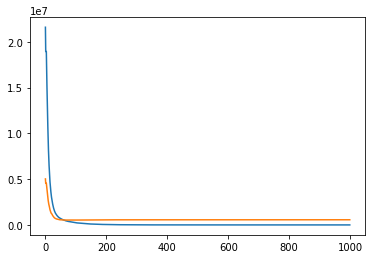

In [71]:
base = DecisionTreeRegressor(criterion='mse', max_leaf_nodes=5)
model = GradientBoostingAlgorithm3_version2(base, boosting_loss, 0.1, verbose=True)
model.fit(X_train, Y_train, num_steps=1000)

err_train = []
err_val = []
for i in range(1000):
    err_train.append(boosting_loss.calculate(model.predict(X_train, n_steps=i), Y_train))
    err_val.append(boosting_loss.calculate(model.predict(X_val, n_steps=i), Y_val))
plt.plot(err_train)
plt.plot(err_val)
print(np.min(err_train))
print(np.min(err_val))

In [11]:
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression

X_train, X_val, Y_train, Y_val = train_test_split(*make_regression(n_samples=1000), test_size=0.2)

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [16]:
base = DecisionTreeRegressor(criterion='mse', max_leaf_nodes=50)
boosting_loss = MeanSquaredLoss()

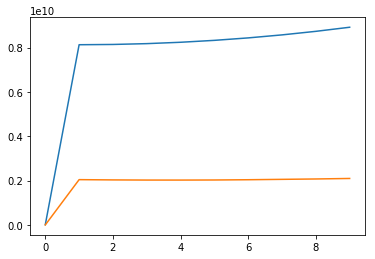

In [78]:
model = GradientBoostingAlgorithm1(base, boosting_loss)
model.fit(X_train, Y_train, num_steps=10)

err_train = []
err_val = []
for i in range(10):
    err_train.append(boosting_loss.calculate(model.predict(X_train, n_steps=i), Y_train))
    err_val.append(boosting_loss.calculate(model.predict(X_val, n_steps=i), Y_val))
plt.plot(err_train)
plt.plot(err_val)

134365.1716552463
344517.2354112712


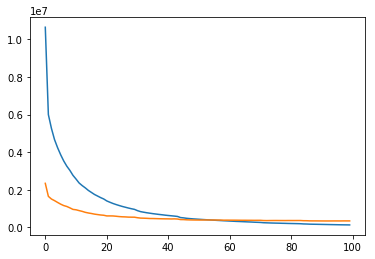

In [113]:
model = GradientBoostingAlgorithm2(base, boosting_loss)
model.fit(X_train, Y_train, num_steps=100)

err_train = []
err_val = []
for i in range(100):
    err_train.append(boosting_loss.calculate(model.predict(X_train, n_steps=i), Y_train))
    err_val.append(boosting_loss.calculate(model.predict(X_val, n_steps=i), Y_val))
plt.plot(err_train)
plt.plot(err_val)
print(np.min(err_train))
print(np.min(err_val))

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
3393188.458353737
903843.1142095964


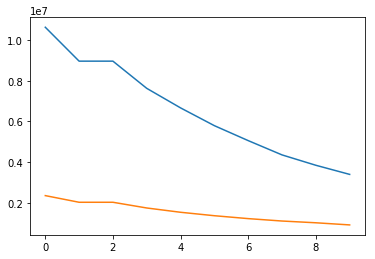

In [157]:
base = DecisionTreeRegressor(criterion='mse', max_leaf_nodes=5)
model = GradientBoostingAlgorithm3(base, boosting_loss, 0.1, verbose=True)
model.fit(X_train, Y_train, num_steps=10)

err_train = []
err_val = []
for i in range(10):
    err_train.append(boosting_loss.calculate(model.predict(X_train, n_steps=i), Y_train))
    err_val.append(boosting_loss.calculate(model.predict(X_val, n_steps=i), Y_val))
plt.plot(err_train)
plt.plot(err_val)
print(np.min(err_train))
print(np.min(err_val))

In [85]:
tree = DecisionTreeRegressor(min_samples_leaf=10)
tree.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [86]:
leaf_indices = tree.apply(x)

In [122]:
for item in filter(lambda arr: len(arr) > 0, 
            map(lambda index: np.arange(0, x.shape[0])[leaf_indices == index],
                np.arange(0, tree.tree_.node_count)
               )
          ):
    #print(type(item))
    #print(len(item))
    print(x[item])

[[ 1.45505154  1.7573291  -0.61543527 ...  1.04452009  0.03727193
  -2.72034528]
 [ 0.98718782 -1.04044824  1.32840367 ... -0.88255417 -0.57517063
  -1.81613094]
 [-0.04492608  0.42863168 -0.39922943 ... -1.8880456  -0.08565384
  -0.83661781]
 ...
 [-0.18201042 -0.35049209  1.29595467 ... -1.6969439  -0.14822162
  -1.51799507]
 [ 1.47827576 -0.05547247 -1.47249061 ...  1.12496947 -0.64314024
   0.08580278]
 [-0.48213295  1.14696465  0.07275182 ...  0.4402683   2.10045348
  -0.63966088]]
[[-0.19492831 -0.34914142  0.48313598 ...  0.05230692  0.57883005
  -0.6501809 ]
 [-0.28885217 -0.32539702  0.74550312 ...  0.47391177  0.04230628
  -1.29135401]
 [-1.86127564  0.90990577 -3.08417508 ...  2.2554111  -1.08515048
   2.493847  ]
 ...
 [-2.26250271  0.25668723  0.6599257  ... -2.29164682  1.34886391
  -1.66909338]
 [-1.5327767   0.30304171 -0.32695066 ... -0.76509207 -0.08945121
  -2.30493168]
 [-0.56798964  0.08070227  0.55344541 ...  1.39552493 -1.40623745
  -1.02986424]]
[[-1.13639683  0